# Introduction to TensorFlow and Keras

TensorFlow is Google's machine learning programing language. TensorFlow is a very general tools for constructing artificial neural networks, both as operation trees and as more topologically complicated networks. TensorFlow's nodes incorporate all of the structure we discussed in the lecture, including most importantly the reverse autodiff partial derivative information.

It's important to remember that using TensorFlow for computations proceeds in two parts:

1. __Construct a graph:__ In this step, create a pattern for the network by defining all of our nodes (input, output, constant, multipliers, LSUs, etc) and connecting them. You also specify their initial values. At this stage no construction has been done. 

2. __Instantiate the model:__ Start a tensor flow __session__ and instantiate the model. An instantiation of the neural network actually creates a copy of all the variables in memory and stores their initial values in them. I

3. __Running the graph:__  Within the TensorFlow __session__, begin running/training the network. 

<img src = "https://www.tensorflow.org/images/tensors_flowing.gif">

Higher level tools like Keras hide the details of the initialization and session and streamline this process by including pre-made versions of common architectures. 

This lab will consist of three parts: 

* __Part 1__: First, we will show how to create a simple computational tree using TensorFlow and how to run it using a session. 
* __Part 2__: Second, we will create a single layer perceptron with TensorFlow and use it to classify the binary labeling.
* __Part 3__: Finally, we will create a multilayer perceptron with TensorFlow and use it to classify the binary labeling.

#### Getting TensorFlow and Keras

If you are on Google Colab, TensorFlow and Keras are automatically installed. If you are running Jupyter locally use the anaconda prompt to install using 

    $ pip install tensorflow
$ pip install keras

* Windows: Open "Anaconda Prompt" from the start menu or from Cortana's search. 
* OSX: Open terminal, you should directly be able to use pip from there. 
* Linux: Open terminal, you should directly be able to use pip from there. 

For more information, see https://www.tensorflow.org/install and https://keras.io/#installation.

This lab follows Chapters 9 and 10 from *Hands-On Machine Learning with Scikit_Learn & TensorFlow*.

## Loading TensorFlow

After TensorFlow is installed restart your kernel. The code below loads Tensorflow and then sets the random seeds for both TensorFlow and numpy. This makes your results consistent across runs, you can also use the `reset_graph()` function to clear the default graph. 

In [2]:
import numpy as np
import tensorflow as tf

# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph() # Sync up all of our seeds. 

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Basic Operations with TensorFlow

We will start by making the simple operation tree below. Our first step is to set up the graph. We will define TensorFlow variables using 

* `tf.Variable(value, name="VarName")` Creates a single 32 bit float TensorFlow variable node. Name it is optional, bit will make it easier to call within TensorFlow. 

You can use the basic arithmetic operations to construct a graph, but you still need to use a TensorFlow session to run one. For example, to create a graph which computes
$$
X^2Y + Y -4\,,
$$
initialized so that $X=3$ and $Y = 2$ we can use:

In [51]:
X = tf.Variable(2, name="X")
Y = tf.Variable(2, name="Y")

f = X*X*Y + Y - 4
f

<tf.Tensor 'sub:0' shape=() dtype=int32>

Running the code above, you'll see that `f` returns 

`<tf.Tensor 'sub_2:0' shape=() dtype=int32>`

instead of a number. This is because TensorFlow has created a placeholder graph for `X`, `Y` and `f` but it has neither initialized anything (that is created the node objects in memory) or evaluated anything yet. 

To evaluate, we need to create a TensorFlow __session__. A TensorFlow session is a connection between Python and the C++ backend that actually runs TensorFlow. 

* `sess = tf.Session()` - Create a TensorFlow session. This connects the variables and graphs we define in Python to the tensorflow backend. 

Se then __initialize__ the variable using

* `sess.run(X.initializer)` - The session `sess` tells TensorFlow to initialize the variable `X`. This actually stores the node `X` in memory. 

The code below starts a session, saves it in the variable `sess` for future use and then initialized the graph within it.

In [52]:
sess = tf.Session()
sess.run(X.initializer)
sess.run(Y.initializer)
result = sess.run(f)
print(result)

# Be sure to clean up after yourself, otherwise you could 
# accadentally be building a graph on top of another one.
sess.close() 

6


A cleaner way to keep track of the session is to use `with tf.session() as sess`. This establishes the global session and `sess` as one in the same so you can write to `sess` either with or without referencing it. [See here for exactly what `with` is doing](http://effbot.org/zone/python-with-statement.htm)

In [53]:
with tf.Session() as sess:
    X.initializer.run()
    Y.initializer.run()
    result = f.eval()

result

6

When you attempt to evaluate a node, TensorFlow traces the nodes dependency back and evaluates all the prior nodes in the graph. We may also initialize all variables at once with the global variable initializer

* `tf.global_variables_initializer()` Creates a global variable initializer node which can be run to initialize all variables.


In [6]:
w = tf.Variable(4, name = "w")
x = w + 4
y = w**2
z = y + 2

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    print(x.eval())  ## When you run this node, nodes x and w are evaualted but y and z are not!
    print(y.eval())  ## When you run this node, nodes x, y and w are evaualted but z is not!
    print(z.eval())  ## When you run this node, nodes x, y, z and w are all evaluated. 

8
16
18


Note, that each time `print(x.eval())` is run all the node values must be calculated again. TensorFlow does not reuse the values unless instructed to. The only thing that TensorFlow stores between runs are the declared variables, in this `w`. The code above evaluates `x` and `y` multiple times. 

## Operation Trees with TensorFlow

Lets use TensorFlow compute our linear regression solution $\beta = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$. 

The __computation tree__ or __dataflow graph__ is written using the nodes for each operation. We will use the following nodes

* `tf.matmul(A,B)` - Performs the matrix multiplication $A\times B$. 
* `tf.matrix_inverse(A)` - Performs the matrix inversion $A^{-1}$.
* `tf.matrix_transpose(A)` - Performs the matrix transposition $A^{T}$. 

Try to construct the matrix beta below for the breast cancer data set:

In [7]:
from sklearn.datasets import load_breast_cancer
reset_graph() 

cancer = load_breast_cancer()
m,n = cancer.data.shape

cancer_bias = np.c_[np.ones((m,1)),cancer.data]

X = tf.constant( cancer_bias, dtype=tf.float32, name="X" )
y = tf.constant( cancer.target.reshape(-1,1), dtype=tf.float32, name="y" )

XT = tf.matrix_transpose(X)

## Use the functions above to define beta

beta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT,X)),XT),y)

with tf.Session() as sess:
    print(beta.eval())

[[ 3.03878736e+00]
 [ 2.12410808e-01]
 [-4.60297614e-03]
 [-2.29832307e-02]
 [-3.20278807e-04]
 [-1.23483062e-01]
 [ 4.20599270e+00]
 [-1.41062689e+00]
 [-2.09827614e+00]
 [-8.70230198e-02]
 [-1.13239765e-01]
 [-4.35129106e-01]
 [ 6.62715314e-03]
 [ 2.24362314e-02]
 [ 9.22825246e-04]
 [-1.57302608e+01]
 [-9.76098776e-02]
 [ 3.58916402e+00]
 [-1.05665703e+01]
 [-1.68658531e+00]
 [ 7.10698318e+00]
 [-1.94866821e-01]
 [-7.15283910e-03]
 [ 2.38883239e-03]
 [ 1.01130910e-03]
 [-5.42705894e-01]
 [-6.51488602e-02]
 [-3.82766724e-01]
 [-4.58982110e-01]
 [-5.60118496e-01]
 [-4.27969170e+00]]


### Visualizing TensorFlow Graphs

TensorFlow has a robust visualization suite called [Tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard). To use Tensorboard we must add a summary node to output the results of running the network. The line of code

    tf.summary.FileWriter('./graphs', sess.graph)
    
write the initialized graph out to the subfolder ./graphs. 

In [8]:
with tf.Session() as sess:
    print(beta.eval())
    writer = tf.summary.FileWriter('./graphs', sess.graph)

[[ 3.03878736e+00]
 [ 2.12410808e-01]
 [-4.60297614e-03]
 [-2.29832307e-02]
 [-3.20278807e-04]
 [-1.23483062e-01]
 [ 4.20599270e+00]
 [-1.41062689e+00]
 [-2.09827614e+00]
 [-8.70230198e-02]
 [-1.13239765e-01]
 [-4.35129106e-01]
 [ 6.62715314e-03]
 [ 2.24362314e-02]
 [ 9.22825246e-04]
 [-1.57302608e+01]
 [-9.76098776e-02]
 [ 3.58916402e+00]
 [-1.05665703e+01]
 [-1.68658531e+00]
 [ 7.10698318e+00]
 [-1.94866821e-01]
 [-7.15283910e-03]
 [ 2.38883239e-03]
 [ 1.01130910e-03]
 [-5.42705894e-01]
 [-6.51488602e-02]
 [-3.82766724e-01]
 [-4.58982110e-01]
 [-5.60118496e-01]
 [-4.27969170e+00]]


Now that we've saved out the file (which will include all of the breast cancer data so the file will be larger than you'd expect), open the command line (conda for Windows, terminal of *nix), navigate to the directory containing the lab file, and type

`tensorboard --logdir "./graphs"`

to start up Tensorboard. You should see the following picture for the graph with cane be zoomed and manipulated. 
<img width= 300px src="http://i67.tinypic.com/2hgaiqd.png">

TensorFlow does its best to organize the graph, but it doesn't read left to right. Not that the dimensions of the tensors label the edges of the graph. TensorBoard is a very deep piece of TensorFlow and summary can log a lot of information about your graph and nodes. We will not go too far into it at this time. 

#### Organizing TensorFlow Graphs

TensorBoard visualizations quickly get out of hand after more than a handful of nodes are added, so its helpful to organize graphs using `with tf.name_scope("name"):`. This command allows us to organize our nodes into larger collections of nodes (or layers) and can be nested. For example, we putting $X$, $Y$ and $X^T$ in a scope called "Inputs" and the multiplication in a scope called "Compute" yields

<img width = 200 src = "http://i63.tinypic.com/atvle1.jpg">

Where we can open up the scopes to find 

<img width = 200 src = "http://i66.tinypic.com/mjtpp3.png">





When we open the graph after running the code below we will see

In [9]:
reset_graph() 
with tf.name_scope("Inputs"):
    X = tf.constant( cancer_bias, dtype=tf.float32, name="X" )
    y = tf.constant( cancer.target.reshape(-1,1), dtype=tf.float32, name="y" )
    XT = tf.matrix_transpose(X)

with tf.name_scope("Compute"):
    beta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT,X)),XT),y)

with tf.Session() as sess:
    writer = tf.summary.FileWriter('./graphs', sess.graph)
    print(beta.eval())

[[ 3.03878736e+00]
 [ 2.12410808e-01]
 [-4.60297614e-03]
 [-2.29832307e-02]
 [-3.20278807e-04]
 [-1.23483062e-01]
 [ 4.20599270e+00]
 [-1.41062689e+00]
 [-2.09827614e+00]
 [-8.70230198e-02]
 [-1.13239765e-01]
 [-4.35129106e-01]
 [ 6.62715314e-03]
 [ 2.24362314e-02]
 [ 9.22825246e-04]
 [-1.57302608e+01]
 [-9.76098776e-02]
 [ 3.58916402e+00]
 [-1.05665703e+01]
 [-1.68658531e+00]
 [ 7.10698318e+00]
 [-1.94866821e-01]
 [-7.15283910e-03]
 [ 2.38883239e-03]
 [ 1.01130910e-03]
 [-5.42705894e-01]
 [-6.51488602e-02]
 [-3.82766724e-01]
 [-4.58982110e-01]
 [-5.60118496e-01]
 [-4.27969170e+00]]


### (Exercise)

Create a run the graph for the solution to ridge regression:

$$
\beta_{ridge} = (\mathbf{X}^T\mathbf{X} + kI)^{-1}\mathbf{X}^T\mathbf{y}
$$

## Single Layer Perceptron In TensorFlow

Lets build the two input, single layer perceptron, from the lecture. The two input perceptron 

<img width=800px src="http://i66.tinypic.com/2h5i5a8.png">

is constructed from input layers, a bias variable $b$, a summation layer and a sigmoid layer. The the sigmoid function $\sigma(x) = (1+e^{-x})^{-1}$ is a smooth function that generalizes the step function. 

<table><tr><td width=200px>
    $$\sigma(x) = \frac{1}{1+e^{-x}}\,,$$</td><td>
<img width=300px src="https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg">
    </td></tr></table>

We will train the perceptron on the XOR adversarial distribution:

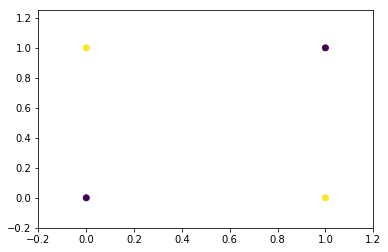

In [25]:
from matplotlib import pyplot as plt

x = np.array([[0, 0], [1, 0], [1, 1], [0, 1]], np.float32) 
#y = np.array([0, 0, 1, 0], np.float32).reshape(-1,1) # AND distribution
y = np.array([0, 1, 0, 1], np.float32).reshape(-1,1) # XOR distribution

plt.scatter(x[:, 0], x[:, 1], c=y.reshape(-1))
plt.xlim([-0.2, 1.2]); plt.ylim([-0.2, 1.25]);
plt.show()

### Perceptron with Gradient Decent

Setting up our variables, we need to know the number of features `NUM_FEATURES`, the number of epochs (full runs through the whole dataset) to run `NUM_EPOCHS`, and a constant `LEARNING_RATE` for the learning rate $\eta$.

Since we will feed data into $X_1$ and $X_2$ they won't be __variables__, but __placeholders__. A placeholder is a slot of defined size to put data into. 

* `tf.placeholder(tf.float32, shape=[,,])` - A placeholder to feed training data into. The shape should be the shape of the training data.

We will need two __placeholders__, one for the features $X$ and one for the labels $Y$. The dimensions of the placeholders will depend on how many datapoints we train on at each step. Since we will be training using gradient decent the batch size will be all of the data, so the placeholders for $X$ will be a $4\times 2$ vector 


We will also need two TensorFlow __variables__, one for the _bias_ and one for the $\beta$ terms. The LSU computes the function

$$
\hat{y} = \sigma\big(\,\mathbf{X}\beta + b\,\big)\,,
$$

so we need addition node, a multiplication node and a sigmoid mode. The only new one is 

* `tf.sigmoid()` - Compute the sigmoid activation function. 

In [13]:
NUM_FEATURES = 2
NUM_EPOCHS = 20
LEARNING_RATE = 0.5
 
## Set up the function to train    
X = tf.placeholder(tf.float32, shape=[4, 2])
Y = tf.placeholder(tf.float32, shape=[4, 1])
 
BETA = tf.Variable(tf.ones([NUM_FEATURES, 1]), tf.float32)
BIAS = tf.Variable(tf.ones([1, 1]), tf.float32)

yHat = tf.sigmoid( tf.matmul(X, BETA) +  BIAS )

When training with mini-batch gradient decent, if during the $n$'th training step we train on $M$ data points $x_{n_1},\ldots, x_{n_M}$ then we update the perceptron weights by the average of the SGD step

$$
w^{(n+1)} = w^{(n)} + \frac{\eta}{M}\sum_{i=1}^M(y_{n_i}-\hat y_{n_i})x_{n_i}\,.
$$

As usual we are using the convention that all vector are column vectors unless explicitly transposed.

When $M=N$, this is of course batch gradient decent, and when $M=1$ it is Stochastic Gradient Decent. We will start with batch gradient decent and move on the mini-batch shortly. For batch gradient decent, the update step is

$$
w^{(n+1)} = w^{(n)} + \frac{\eta}{N}\mathbf{X}^T(\mathbf{y}-\hat{\mathbf{y}})\,.
$$

To update the bias, we remember that the bias can be computed by including a column of 1's in $\mathbf{X}$. Since we are treating the bias separately we update `b` by the formula above with $x_i$ set to 1:

$$
b^{(n+1)} = b^{(n)} + \frac{\eta}{N}\sum_{i=1}^N \mathbf{y}_i-\hat{\mathbf{y}}_i\,.
$$

This we be implemented with a `tf.reduce_sum` node:

* `tf.reduce_sum(Y, n)` - Sum the matrix `Y` along the dimension `n`.

Finally, we update the values at once by using `tf.Variable.assign()` to update the variables. By using a `tf.group` we update both the `BETA` variable and the `BIAS` variable at the same time. Since TensorFlow traces each node backward evaluating each node for each computation, we should always wrap the last steps in the network in a single node so that the whole network behind it only run once at each step. 

In [26]:
err = Y - yHat

BETA_ = BETA + LEARNING_RATE * tf.matmul(tf.transpose(X), err )/4
BIAS_ = BIAS + LEARNING_RATE * tf.reduce_sum(err, 0)/4
 
step = tf.group(BETA.assign(BETA_), BIAS.assign(BIAS_)) # Update the values of weights and biases. 

We now set up the session, initialize the variables and train the network. We run the training `NUM_ITER` times. The actual line of code that does the training is

    sess.run([step], feed_dict={X: x, Y: y})

At each step, this runs the node `step`, where we are feeding the data `x` into the placeholder `X` and the labels `y` into the placeholder `Y`. We then save out the parameters.  

In [27]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for k in range(NUM_EPOCHS):
        sess.run([step], feed_dict={X: x, Y: y})
        beta = np.squeeze(sess.run(BETA))
        bias = np.squeeze(sess.run(BIAS))

print('Beta: ' + str(beta))
print('Bias: ' + str(bias))

Beta: [0.18991005 0.18991005]
Bias: -0.18905309


Let us plot the lines at each step:

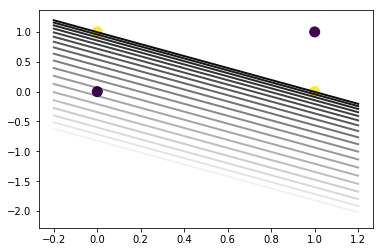

In [33]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for k in range(NUM_EPOCHS):
        sess.run([step], feed_dict={X: x, Y: y})
        beta = np.squeeze(sess.run(BETA))
        bias = np.squeeze(sess.run(BIAS))

        # Now plot the fitted line. We need only two points to plot the line
        plot_x = np.array([np.min(x[:, 0] - 0.2), np.max(x[:, 1]+0.2)])
        plot_y = - 1 / beta[1] * (beta[0] * plot_x + bias)
        plot_y = np.reshape(plot_y, [2, -1])
        plot_y = np.squeeze(plot_y)

        plt.plot(plot_x, plot_y, color='k', linewidth=2, alpha=(k/NUM_EPOCHS))

plt.scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=100, alpha = 1, cmap='viridis')
plt.show()

### (Exercise):

How many will it take for the perceptron to stabilize? What happens if we instead use the XOR distribution?

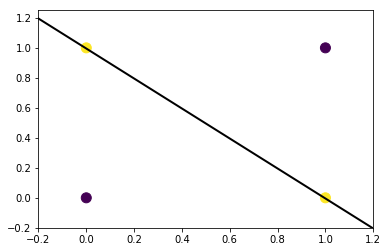

In [31]:
plt.scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=100, cmap='viridis')
plt.plot(plot_x, plot_y, color='k', linewidth=2)
plt.xlim([-0.2, 1.2]); plt.ylim([-0.2, 1.25]);
plt.show()

## Mini-Batch Gradient Decent for the Perceptron

To implement mini-batch gradient decent, we need to fix a batch size `BATCH_SIZE` and adjust our `X` and `Y` placeholders to be of size `BATCH_SIZE`. We then need to randomize training data `x` and `y` that we feed to the network at each step:

    sess.run([step], feed_dict={X: x, Y: y})
    
So we will write a function to fetch a batch:

In [34]:
NUM_FEATURES = 2
NUM_EPOCHS = 20
LEARNING_RATE = 0.5
BATCH_SIZE = 2
N = 4
N_BATCHES = N/BATCH_SIZE

## Set up the function to train    
X = tf.placeholder(tf.float32, shape=[BATCH_SIZE, 2])  ## Adjust to batch size
Y = tf.placeholder(tf.float32, shape=[BATCH_SIZE, 1])  ## Adjust to batch sise
 
BETA = tf.Variable(tf.ones([NUM_FEATURES, 1]), tf.float32)
BIAS = tf.Variable(tf.ones([1, 1]), tf.float32)

yHat = tf.sigmoid( tf.matmul(X, BETA) +  BIAS )

err = Y - yHat

BETA_ = BETA + LEARNING_RATE * tf.matmul(tf.transpose(X), err )/4
BIAS_ = BIAS + LEARNING_RATE * tf.reduce_sum(err, 0)/4
 
step = tf.group(BETA.assign(BETA_), BIAS.assign(BIAS_)) # Update the values of weights and biases. 


with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    writer = tf.summary.FileWriter('./graphs', sess.graph)

    for k in range(NUM_EPOCHS):
        for j in range(BATCH_SIZE):
            perm = np.random.permutation(N)            # Generate a random permuataion of the indices
            ind = perm[j:j+BATCH_SIZE]                 # Get a BATCH_SIZE of indicies
            sess.run([step], feed_dict={X: x[ind], Y: y[ind]})
            
        beta = np.squeeze(sess.run(BETA))
        bias = np.squeeze(sess.run(BIAS))

print('Beta: ' + str(beta))
print('Bias: ' + str(bias))

Beta: [-0.11374661  0.00367005]
Bias: -0.04776216


With the plotting we have

Beta: [-0.4601719   0.07634456]
Bias: -0.022635318


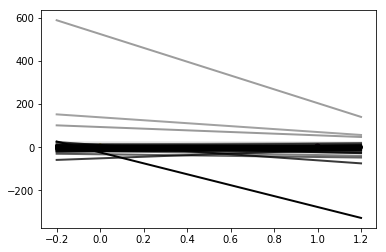

In [35]:
NUM_EPOCHS = 200
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for k in range(NUM_EPOCHS):
        for j in range(BATCH_SIZE):
            perm = np.random.permutation(N)            # Generate a random permuataion of the indices
            ind = perm[j:j+BATCH_SIZE]                 # Get a BATCH_SIZE of indicies
            sess.run([step], feed_dict={X: x[ind], Y: y[ind]})
            
        beta = np.squeeze(sess.run(BETA))
        bias = np.squeeze(sess.run(BIAS))
        
                # Now plot the fitted line. We need only two points to plot the line
        plot_x = np.array([np.min(x[:, 0] - 0.2), np.max(x[:, 1]+0.2)])
        plot_y = - 1 / beta[1] * (beta[0] * plot_x + bias)
        plot_y = np.reshape(plot_y, [2, -1])
        plot_y = np.squeeze(plot_y)

        plt.plot(plot_x, plot_y, color='k', linewidth=2, alpha=(k/NUM_EPOCHS))
        
plt.scatter(x[:, 0], x[:, 1], c=y.reshape(-1))  

print('Beta: ' + str(beta))
print('Bias: ' + str(bias))

## Multilayer Perceptron In TensorFlow

Lets now construct the multilayer perceptron

<img width=400px src="http://i63.tinypic.com/inv0b9.png">

This is in principle no different, we just need to add in another perceptron layer. Notice that a single perceptron layer is just a the following matrix transform:

$$
\sigma(X^T \mathbf{W}_i + \mathbf{b}) = \sigma\left (\,\,\left(\begin{matrix} x_1 \\ x_2 \end{matrix}\right)
\left(\begin{matrix} w_{11} & w_{12} \\ w_{21} & w_{22} \end{matrix}\right) + \left(\begin{matrix} b_1 \\ b_2 \end{matrix}\right)\,\,\right)
$$

This gives us a cleaner way to build the network. 

In the code below, I will carefully build the multilayer perceptron network, documenting each step. The network will be composed of four layers and an optimizer. The layers are distributed as follows:

* __Input__: The input layer containing the placeholders for $X$ and $Y$. We assume $Y$ is in a one hot encoding, so `NUM_LABELS` will be 2. Furthermore, specifying `None` for axis 0 of the input shape allows TensorFlow to decide the vector length at runtime based on the size of the batch passed. 
* __Layer1__: Layer 1 computes $\mathbf{X}\mathbf{W}_1 + b_1$ where $\mathbf{W}_1$ is a $2\times N1$ matrix and $b$ is a $N1$ vector. We use a sigmoid $\sigma$ activation function to mimic the step function of the perceptron. We save the output in $\mathbf{Z}_1$. 
* __Layer2__: Layer 2 computes $\mathbf{Z}_1\mathbf{W}_2 + b_2$ where $\mathbf{W}_2$ is a $N1\times 2$ matrix and $b_2$ is a 2 vector. We again use a sigmoid $\sigma$ activation function to mimic the step function of the perceptron. We save the output in $O$. 
* __Loss__: We compute the softmax cross entropy with logits. __Softmax__ normalizes the vector $O$ into a probability vector, so the entries sum to 1. __Cross entropy__ is minus log of the probability then guessed for the correct label. 
* __Optimizer__: For training, we need to add an optimizer. In this case we use `tf.train.GradientDescentOptimizer` and let TensorFlow do the work of backpropagation for us. We then set `training_op` to minimize the result of the loss computed above. 

Finally, we add the global variable initializer. 

In [1100]:
import tensorflow as tf
import numpy as np

reset_graph()

NUM_FEATURES = 2
NUM_LABELS = 2
NUM_EPOCHS = 20
LEARNING_RATE = .01
BATCH_SIZE = 2
N = 4
N_BATCHES = N/BATCH_SIZE

N1 = 4  # Number of nodes in first perceptron layer

## Set up the function to train    
X = tf.placeholder(tf.float32, shape=(None,NUM_FEATURES))  ## Adjust to batch size
Y = tf.placeholder(tf.float32, shape=(None,NUM_LABELS))  ## Adjust to batch sise

## Layer 1
with tf.name_scope("Layer1"):
    W1 = tf.Variable(tf.random_normal([NUM_FEATURES, N1]), tf.float32)
    B1 = tf.Variable(tf.random_normal([1, N1]), tf.float32)
    Z1 = tf.nn.sigmoid(tf.matmul(X,W1)+ B1)

## Layer 2
with tf.name_scope("Layer2"):
    W2 = tf.Variable(tf.random_normal([N1, NUM_LABELS]), tf.float32)
    B2 = tf.Variable(tf.random_normal([1, NUM_LABELS]), tf.float32)
    O = tf.nn.sigmoid(tf.matmul(Z1,W2)+ B2)

with tf.name_scope("Loss"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=O)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("Optimize"):   
    optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
    training_op = optimizer.minimize(loss) 

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Now, we actually train the network. 

* __Setup__: We initialize the training data to either the XOR or AND distribution. We also set up a $20\times 20$ grid to check the result of our fit.

* __Initializing__: Inside a session, initialize our graph variable and output a summary of the network to the `./graphs` folder (note: uncomment this line if you to view the graph structure in TensorBoard). We redefine the data in case it has gotten overwritten at some point. 

* __Training:__ For each epoch, we generate a random permutation of the indices of the training data. We then loop through the indices, feeding a single instance of `X` and `Y` into the network. Note, we must reshape because Python drops the first dimension for single instances. 

* __Remember: We are not saving the weights, so each time you close the session the graph's weights will be reset.__

* __Output:__ Within the same session, we output the contents of the weight matrices. Finally, we predict the label on each element of our generated grid. Note that we must `argmax` the result to get an actual answer. Finally, we plot the resulting fitting. 

Run the code below until you get a reasonable fit. It may take a couple of tries. 

In [1101]:
## Data
x = np.array([[0, 0], [1, 0], [1, 1], [0, 1]], np.float32) 
#y = np.array([0, 0, 1, 0], np.float32) # AND distribution
y = np.array([0, 1, 0, 1], np.float32) # XOR distribution
y_d = np.array(pd.get_dummies(y), np.float32) # XOR distribution

## Generate a grid from [-10,10]x[-10,10] for us to predict on
X1, Y1 = np.meshgrid(np.linspace(-10,10),np.linspace(-10,10))
X2, Y2 = np.meshgrid(np.linspace(-.1,1.1),np.linspace(-.1,1.1))
## To predict on the grid, we must pass it to the network as a Nx2 vector
Z1 = np.concatenate([X1.reshape(-1,1),Y1.reshape(-1,1)],axis=1) 
Z2 = np.concatenate([X1.reshape(-1,1),Y1.reshape(-1,1)],axis=1) 


NUM_EPOCHS = 500
with tf.Session() as sess:
    init.run()
#    writer = tf.summary.FileWriter('./graphs', sess.graph)
    
    for epoch in range(NUM_EPOCHS):
        for i in np.random.permutation(4):
            sess.run(training_op, feed_dict={X:x[i].reshape(1,-1),Y:y_d[i].reshape(-1,2)})
    
    ## Report Weights
    print("The weights W1:\n",sess.run(W1))
    print("The weights B1:\n",sess.run(B1))
    print("The weights W2:\n",sess.run(W2))
    print("The weights B2:\n",sess.run(B2))
    
    ## Predict on the grid
    Y_hat1 = O.eval(feed_dict={X: Z1})
    Y_hat2 = O.eval(feed_dict={X: Z2})

The weights W1:
 [[ 1.0686092  -2.474807   -1.621447   -0.36433503]
 [ 0.39524555  0.26563856  0.99114347 -0.3480598 ]]
The weights B1:
 [[ 0.06373418 -1.0183132  -0.24104863 -0.3632297 ]]
The weights W2:
 [[-1.0978028  -1.4918492 ]
 [-0.3578859   0.21201748]
 [-1.670143   -0.73276114]
 [-0.3462435   0.89198697]]
The weights B2:
 [[1.0676625  0.60627997]]


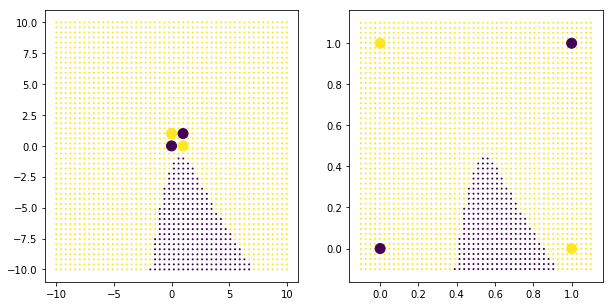

In [40]:
## Reshape prediction back to grid
Y_hat_p1 = np.argmax(Y_hat1,axis=1).reshape(50,50)
Y_hat_p2 = np.argmax(Y_hat2,axis=1).reshape(50,50)

## Plot predicted classifier
f, axes = plt.subplots(1,2,figsize = (10,5))
axes[0].scatter(X1, Y1, c=Y_hat_p1, s=1, cmap='viridis')
axes[0].scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=100, cmap='viridis')

axes[1].scatter(X2, Y2, c=Y_hat_p2, s=1, cmap='viridis')
axes[1].scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=100, cmap='viridis')

## Question:

One reason the code above doesn't always return a good fit despite the fact that a theoretical fit exists is that we are not using the hard step function. Change the code above to try to find a network that has a high probability of correctly fitting the XOR distribution across multiple runs. 

Some things you can change:

* The number of epochs.
* The learning rate.
* The layer sizes.
* More layers.
* Initialization of the weights is marks the starting point for training, and so is hugely important. Try using `tf.zeros`, `tf.ones` or `tf.random_normal(,stdev=.1)` to initialize the weights. 
* What happens if you use ReLU or tanh instead of the sigmoid activation function?
* Try adding an `optimize2` and `optimize3` node with different learning rates. This will allow you to create a __learning schedule__.

## Question:

Construct a perceptron network with at least 3 layers and add a jump connection between layers 1 and 3 to increase training speed. A jump connection is a direct pipe from Layer 1 to to Layer 3, bypassing Layer 2. Such connection can greatly speed up training on very deep, very wide networks by first training the rough structure of the jump network and then fine tuning with the intermediate layers.  

## Question: 

Why is it generally preferable to use a Logistic Regression classifier rather than a classical Perceptron (i.e., a single layer of linear threshold units trained using the Perceptron training algorithm)? How can you tweak a Perceptron to make it equivalent to a Logistic Regression classifier?

## Bonus Question:

Write a perceptron for classifying the MNIST dataset with at least two deep layers. 